## Setup and preprocessing

In [1]:
# main data file
file_path = '../data/data.feather'

import pandas as pd
df = pd.read_feather(file_path)

In [2]:
import numpy as np
import cudf

In [3]:
# Calculate percentage of missing values per column
missing_percentage = df.isnull().mean() * 100

# Calculate total number of missing values
total_missing = df.isnull().sum().sum()

# Calculate percentage of missing values in entire dataset
total_missing_percentage = (total_missing / df.size) * 100

# Display statistics
print("Percentage of missing values per column:")
print(missing_percentage)
print("\nTotal number of missing values:", total_missing)
print("Total cells: ", df.shape[0]*df.shape[1])
print(f"\nPercentage of missing values in entire dataset: {total_missing_percentage:.2f}%")

Percentage of missing values per column:
q2             63.670270
q11            57.789121
q12            67.097161
q13            52.346755
q14            54.473388
                 ...    
gender          2.933992
race           18.936391
gender2         3.223589
gender2_num     3.223589
CA_items        0.000000
Length: 2625, dtype: float64

Total number of missing values: 137897961
Total cells:  179473875

Percentage of missing values in entire dataset: 76.83%


In [4]:
# Select columns where the percentage of missing values is greater than 60%
full_cols = missing_percentage[missing_percentage < 60].index

# Display these columns
subset = df[full_cols]

subset = subset.replace('nan', pd.NA)  # Convert string 'nan' to actual NaN

# One-hot encoding with a "missing" category
encoded_df = pd.get_dummies(subset, dummy_na=True, prefix_sep='_')

In [5]:
import pandas as pd

# Define a function to fill missing values
def fill_values(column):
    if column.dtype.name == 'category' or isinstance(column.dtype, pd.CategoricalDtype) or column.dtype == object:
        # Fill categorical columns with the mode
        return column.fillna(column.mode()[0])
    else:
        # Fill numerical columns with the mean
        return column.fillna(column.mean())

# Apply the function to the DataFrame
filled_df = subset.apply(fill_values)

In [6]:
# One-hot encoding with a "missing" category
encoded_filled_df = pd.get_dummies(filled_df, dummy_na=False, prefix_sep='_')

In [7]:
encoded_filled_gpu = cudf.from_pandas(encoded_filled_df)

## pca run

In [8]:
import cupyx.scipy.sparse as cp_sparse
from cuml.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

dense_data = encoded_filled_gpu.to_cupy()

pca = PCA(n_components=5)
pca_result = pca.fit_transform(dense_data)

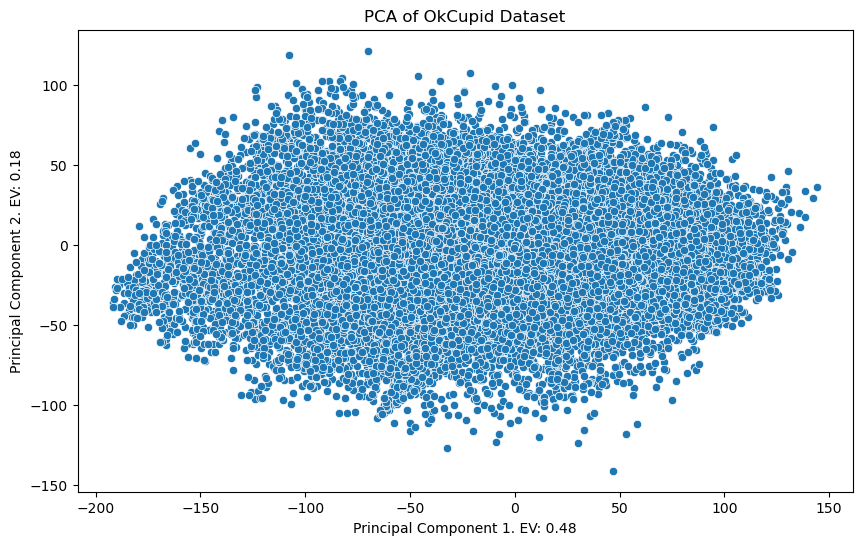

In [9]:
explained_variance = pca.explained_variance_ratio_

# save and visualize
pca_df = cudf.DataFrame(pca_result, columns=[f"PC{i+1}" for i in range(pca.n_components)])  # Updated column names

plt.figure(figsize=(10, 6))
sns.scatterplot(x=pca_df['PC1'].to_pandas(), y=pca_df['PC2'].to_pandas())
plt.title('PCA of OkCupid Dataset')
plt.xlabel(f'Principal Component 1. EV: {explained_variance[0]:.2f}')
plt.ylabel(f'Principal Component 2. EV: {explained_variance[1]:.2f}')
plt.show()

## do various dim reductions

We got the PCA done on a filtered dataset. Now let's get UMAP and T-SNE too. first we'll do it on all columns but then on just the question columns. Eventually we'll want to redo all of this with real imputation, but that's a different investigation. 

### UMAP

In [10]:
import cuml
from cuml.neighbors import NearestNeighbors
from cuml.manifold import UMAP
import cupy as cp

n_neighbors = 91
knn = NearestNeighbors(n_neighbors=n_neighbors, metric='euclidean')
knn.fit(dense_data)
distances, indices = knn.kneighbors(dense_data)

In [11]:
# pre-process knn
umap = UMAP(n_neighbors=n_neighbors, precomputed_knn=(indices, distances))
umap_embedding = umap.fit_transform(dense_data)

[2025-03-06 20:11:43.712] [CUML] [info] Building knn graph using nn descent


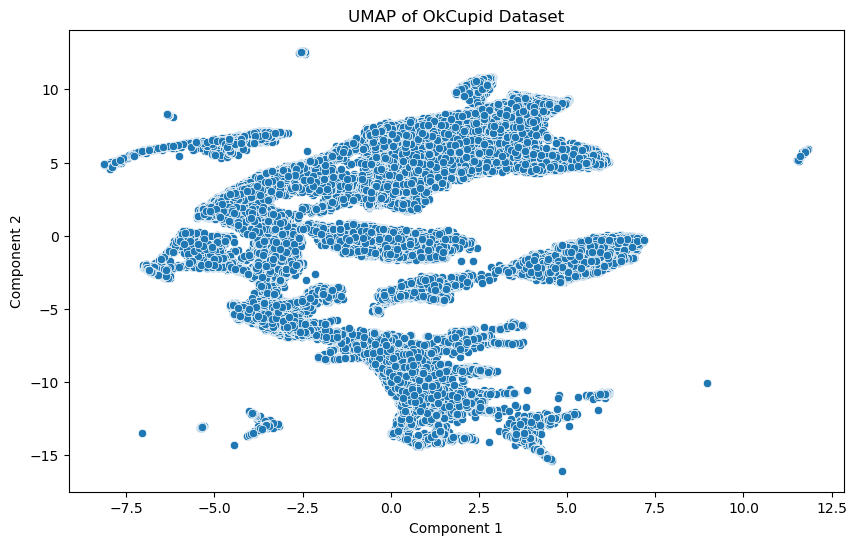

In [12]:
umap_df = pd.DataFrame(umap_embedding.get(), columns=['UM1', 'UM2'])  # Updated column names

plt.figure(figsize=(10, 6))
sns.scatterplot(x=umap_df['UM1'], y=umap_df['UM2'])
plt.title('UMAP of OkCupid Dataset')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

### t-sne

/home/ubuntu/miniconda3/envs/rapids-25.02/lib/python3.12/site-packages/cuml/internals/api_decorators.py:405: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return init_func(self, *args, **filtered_kwargs)


[2025-03-06 21:12:29.327] [CUML] [warning] Perplexity should be within ranges (5, 50). Your results might be a bit strange...
[2025-03-06 21:12:29.327] [CUML] [warning] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...


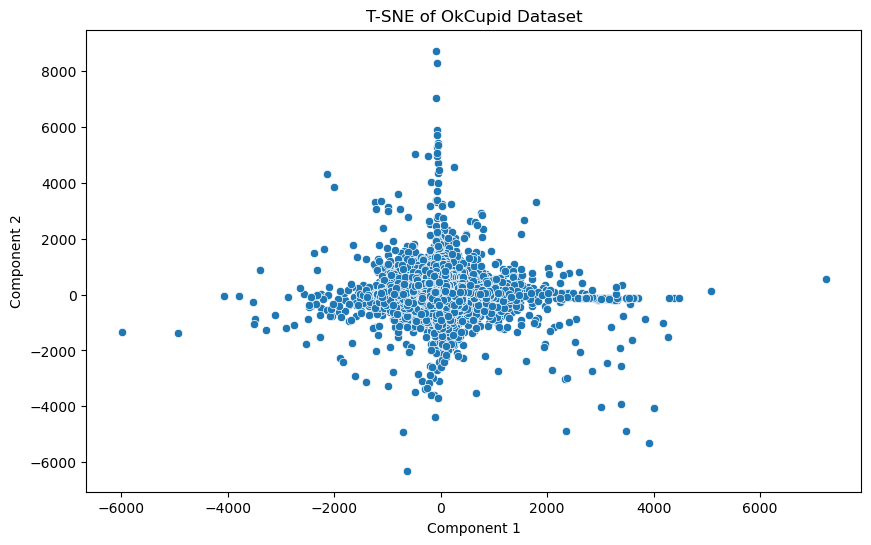

In [48]:
from cuml import TSNE

tsne_graph = umap.graph_.copy()
tsne = TSNE(perplexity = 100, precomputed_knn=tsne_graph, n_neighbors=90)
tsne_embedding = tsne.fit_transform(dense_data)

tsne_df = pd.DataFrame(tsne_embedding.get(), columns=['TS1', 'TS2'])

plt.figure(figsize=(10, 6))
sns.scatterplot(x=tsne_df['TS1'], y=tsne_df['TS2'])
plt.title('T-SNE of OkCupid Dataset')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

## now on just the q columns

In [14]:
import re

encoded_filled_q_gpu = encoded_filled_gpu[[col for col in encoded_filled_gpu.columns if re.match(r'^q\d+', col)]]

### pca

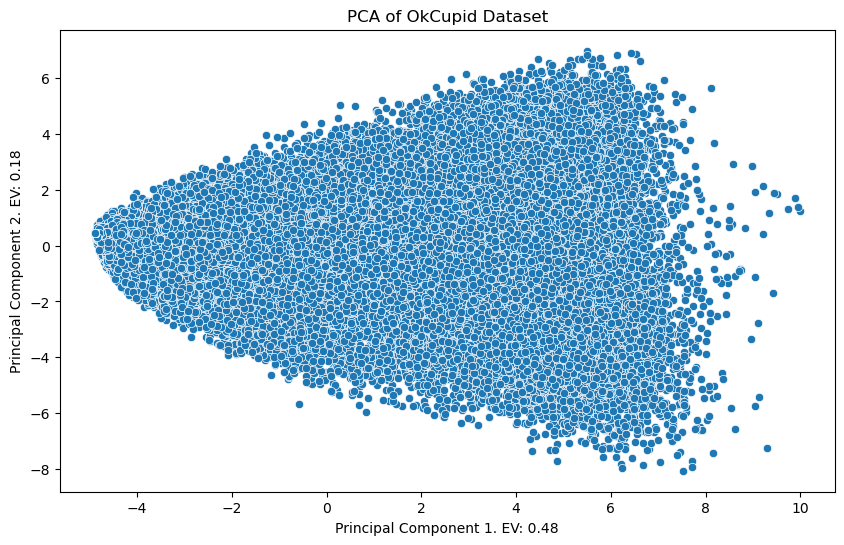

In [15]:
import cupyx.scipy.sparse as cp_sparse
from cuml.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

dense_q = encoded_filled_q_gpu.to_cupy()

pca2 = PCA(n_components=5)
pca_result2 = pca2.fit_transform(dense_q)

explained_variance2 = pca2.explained_variance_ratio_

# save and visualize
pca_df2 = cudf.DataFrame(pca_result2, columns=[f"PC{i+1}" for i in range(pca2.n_components)])  # Updated column names

plt.figure(figsize=(10, 6))
sns.scatterplot(x=pca_df2['PC1'].to_pandas(), y=pca_df2['PC2'].to_pandas())
plt.title('PCA of OkCupid Dataset')
plt.xlabel(f'Principal Component 1. EV: {explained_variance[0]:.2f}')
plt.ylabel(f'Principal Component 2. EV: {explained_variance[1]:.2f}')
plt.show()

In [38]:
import cuml
from cuml.neighbors import NearestNeighbors
from cuml.manifold import UMAP
import cupy as cp

n_neighbors = 15
knn2 = NearestNeighbors(n_neighbors=n_neighbors, metric='euclidean')
knn2.fit(dense_q)
distances2, indices2 = knn2.kneighbors(dense_q)

In [39]:
# pre-process knn
umap2 = UMAP(n_neighbors=n_neighbors, precomputed_knn=(indices2, distances2), min_dist = .3)
umap_embedding2 = umap2.fit_transform(dense_q)

[2025-03-06 20:23:46.753] [CUML] [info] Building knn graph using nn descent


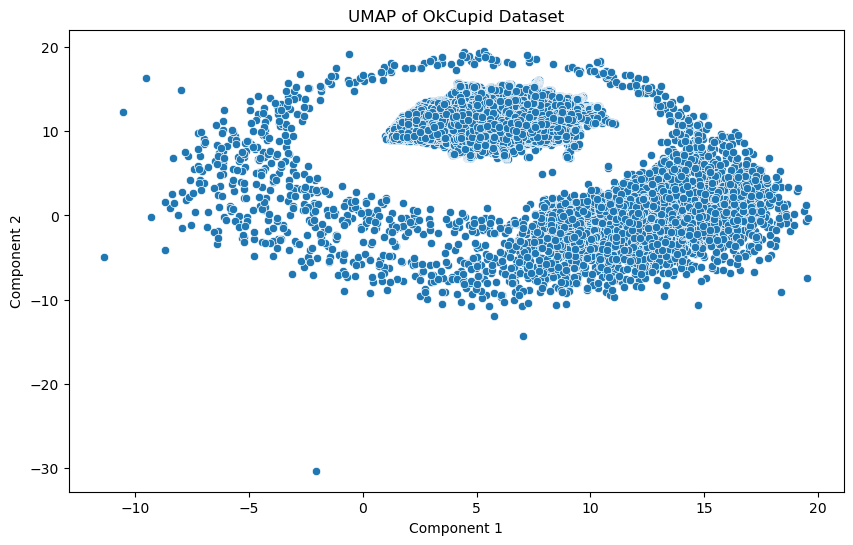

In [42]:
umap_df2 = pd.DataFrame(umap_embedding2.get(), columns=['UM1', 'UM2'])
mask = umap_df2.apply(lambda x: (np.abs(x.values)<50).all(), axis=1)

subset = umap_df2[mask]

plt.figure(figsize=(10, 6))
sns.scatterplot(x=subset['UM1'], y=subset['UM2'])
plt.title('UMAP of OkCupid Dataset')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

/home/ubuntu/miniconda3/envs/rapids-25.02/lib/python3.12/site-packages/cuml/internals/api_decorators.py:405: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return init_func(self, *args, **filtered_kwargs)


[2025-03-06 21:34:08.880] [CUML] [warning] Perplexity should be within ranges (5, 50). Your results might be a bit strange...
[2025-03-06 21:34:08.880] [CUML] [warning] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...


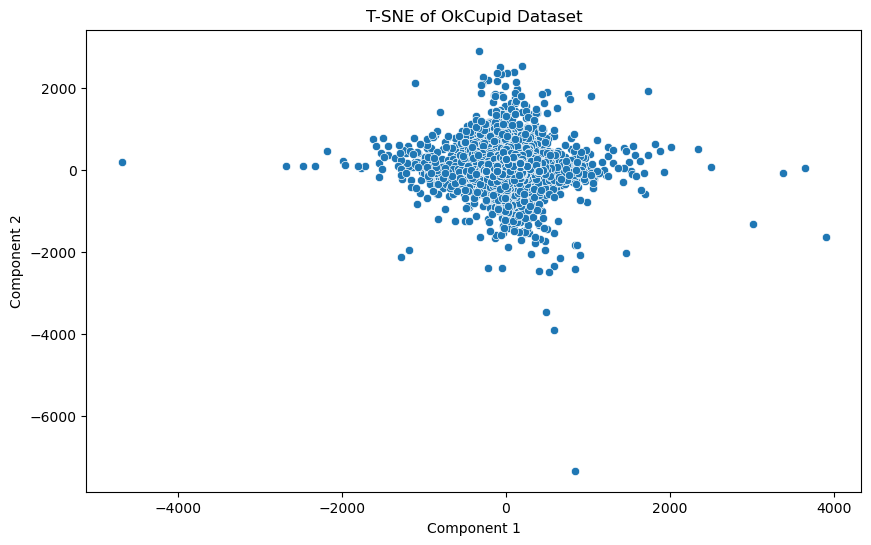

In [50]:
tsne_graph = umap2.graph_.copy()
tsne2 = TSNE(perplexity = 100, precomputed_knn=tsne_graph, n_neighbors=90)
tsne_embedding2 = tsne2.fit_transform(dense_q)

tsne_df2 = pd.DataFrame(tsne_embedding2.get(), columns=['TS1', 'TS2'])

plt.figure(figsize=(10, 6))
sns.scatterplot(x=tsne_df2['TS1'], y=tsne_df2['TS2'])
plt.title('T-SNE of OkCupid Dataset')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

## combine and save data

In [68]:
dfs = [pca_df.to_pandas(), umap_df, tsne_df, pca_df2.to_pandas(), umap_df2, tsne_df2]
combined_df = pd.concat(dfs, axis=1, keys = ["full"]*3 + ["q"]*3)

In [3]:
combined_df.to_parquet("../outputs/dim_reduce.parquet")

NameError: name 'combined_df' is not defined